# Shifted Beta-Geometric Modeling with Cohorts

In this notebook we replicate the main results and figures from ["How to Project Customer Retention"](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_jim_07.pdf) by Hardie & Fader (2007), which introduces the Shifted Beta-Geometric (sBG) model for customer behavior in a discrete contractual setting. It is ideal for business cases involving recurring subscriptions and has the following assumptions:
* Customer cancellation probabilities are Beta-distributed with hyperparameters `alpha` and `beta`.
* Retention rates change over time due to customer heterogeneity.
* All customers in a given cohort began their contract in the same time period.

The last assumption in particular is an ideal application for hierarchical Bayesian modeling.

# Tutorial Notebook Outstanding Tasks
- Merge PR for  `expected_residual_lifetime`
- Merge PR for `expected_retention_elasticity`
- Merge Mean/Polarization index plotting PR
- Merge Static Covariate PR
- Fit regular/highend data to both a cohort and covariate model to replicate research results
- Synthesize time cohort model with covariates to showcase conventional cohort EDA, additional predictive methods, and mean/polar plotting

In [1]:
import pytensor

#set flag to hotfix open c++ errors
pytensor.config.cxx = '/usr/bin/clang++'

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from pymc_marketing import clv
import pymc as pm
from pymc_extras.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Load Data and EDA
Adapt plots from sBG-Individual notebook here.

In [3]:
dataset = pd.read_csv("https://raw.githubusercontent.com/ColtAllen/pymc-marketing/refs/heads/clv-sbg-model/data/sbg_reg_hi_cohorts.csv")

In [4]:
# Add a barplot of raw data here
# aggregation code to re-create data in the next cell used for the research paper
# move imported dataframe generation code into scripts/generate_data/

In [5]:
# Data from research paper
df = pd.DataFrame(
    {
        "regular": [
            100.0,
            63.1,
            46.8,
            38.2,
            32.6,
            28.9,
            26.2,
            24.1,
            22.3,
            20.7,
            19.4,
            18.3,
            17.3,
        ],
        "highend": [
            100.0,
            86.9,
            74.3,
            65.3,
            59.3,
            55.1,
            51.7,
            49.1,
            46.8,
            44.5,
            42.7,
            40.9,
            39.4,
        ],
    }
)
df

,regular,highend
0,100.0,100.0
1,63.1,86.9
2,46.8,74.3
3,38.2,65.3
4,32.6,59.3
5,28.9,55.1
6,26.2,51.7
7,24.1,49.1
8,22.3,46.8
9,20.7,44.5


Figures 4 and 5 show the predicted average churn and retention trends for the two groups.
We can see that predictions nicely match the observed data (black line), even when extrapolating into the time periods that were held-out when fitting the model.

The plots also highlight an interesting implication from the model: 
the retention rates are expected to increase over time, as the more precarious customers gradually drop out. This is a direct consequence of modelling individual churn rates as being fixed over time.

## Model Fitting
#### High-end and Regular User Cohorts

In [6]:
sbg = clv.ShiftedBetaGeoModel(
    data=dataset,
    model_config = {
        "alpha": Prior("HalfFlat",dims="cohort"),
        "beta": Prior("HalfFlat",dims="cohort")
    }
)
sbg.build_model()
sbg.fit(fit_method='map')
sbg.fit_summary()

Output()

alpha[highend]    0.668
alpha[regular]    0.704
beta[highend]     3.806
beta[regular]     1.182
Name: value, dtype: float64

In [7]:
sbg = clv.ShiftedBetaGeoModel(
    data=dataset,
)
sbg.build_model()
sbg.fit(fit_method='mcmc')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

## Contrasting posterior inferences with the repo MLE estimates

The sBG model has 2 population parameters of interest: `alpha` and `beta`. 
These parameters define the population distribution of the latent churn rate distribution `theta`. 
The larger the values of `alpha` and `beta`, the more homogenous the churn rates across different customers. 

The ratio of `alpha` to `beta` tells us the expected churn rates. If `alpha/beta == 0.1`, we expect the average customer to have a `0.1` probability of churning between each time period.

The model fitting agrees with the Maximum Likelihood estimates described in the original paper.
In addition, MCMC sampling, gives us useful information about the uncertainty of the fits.

array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

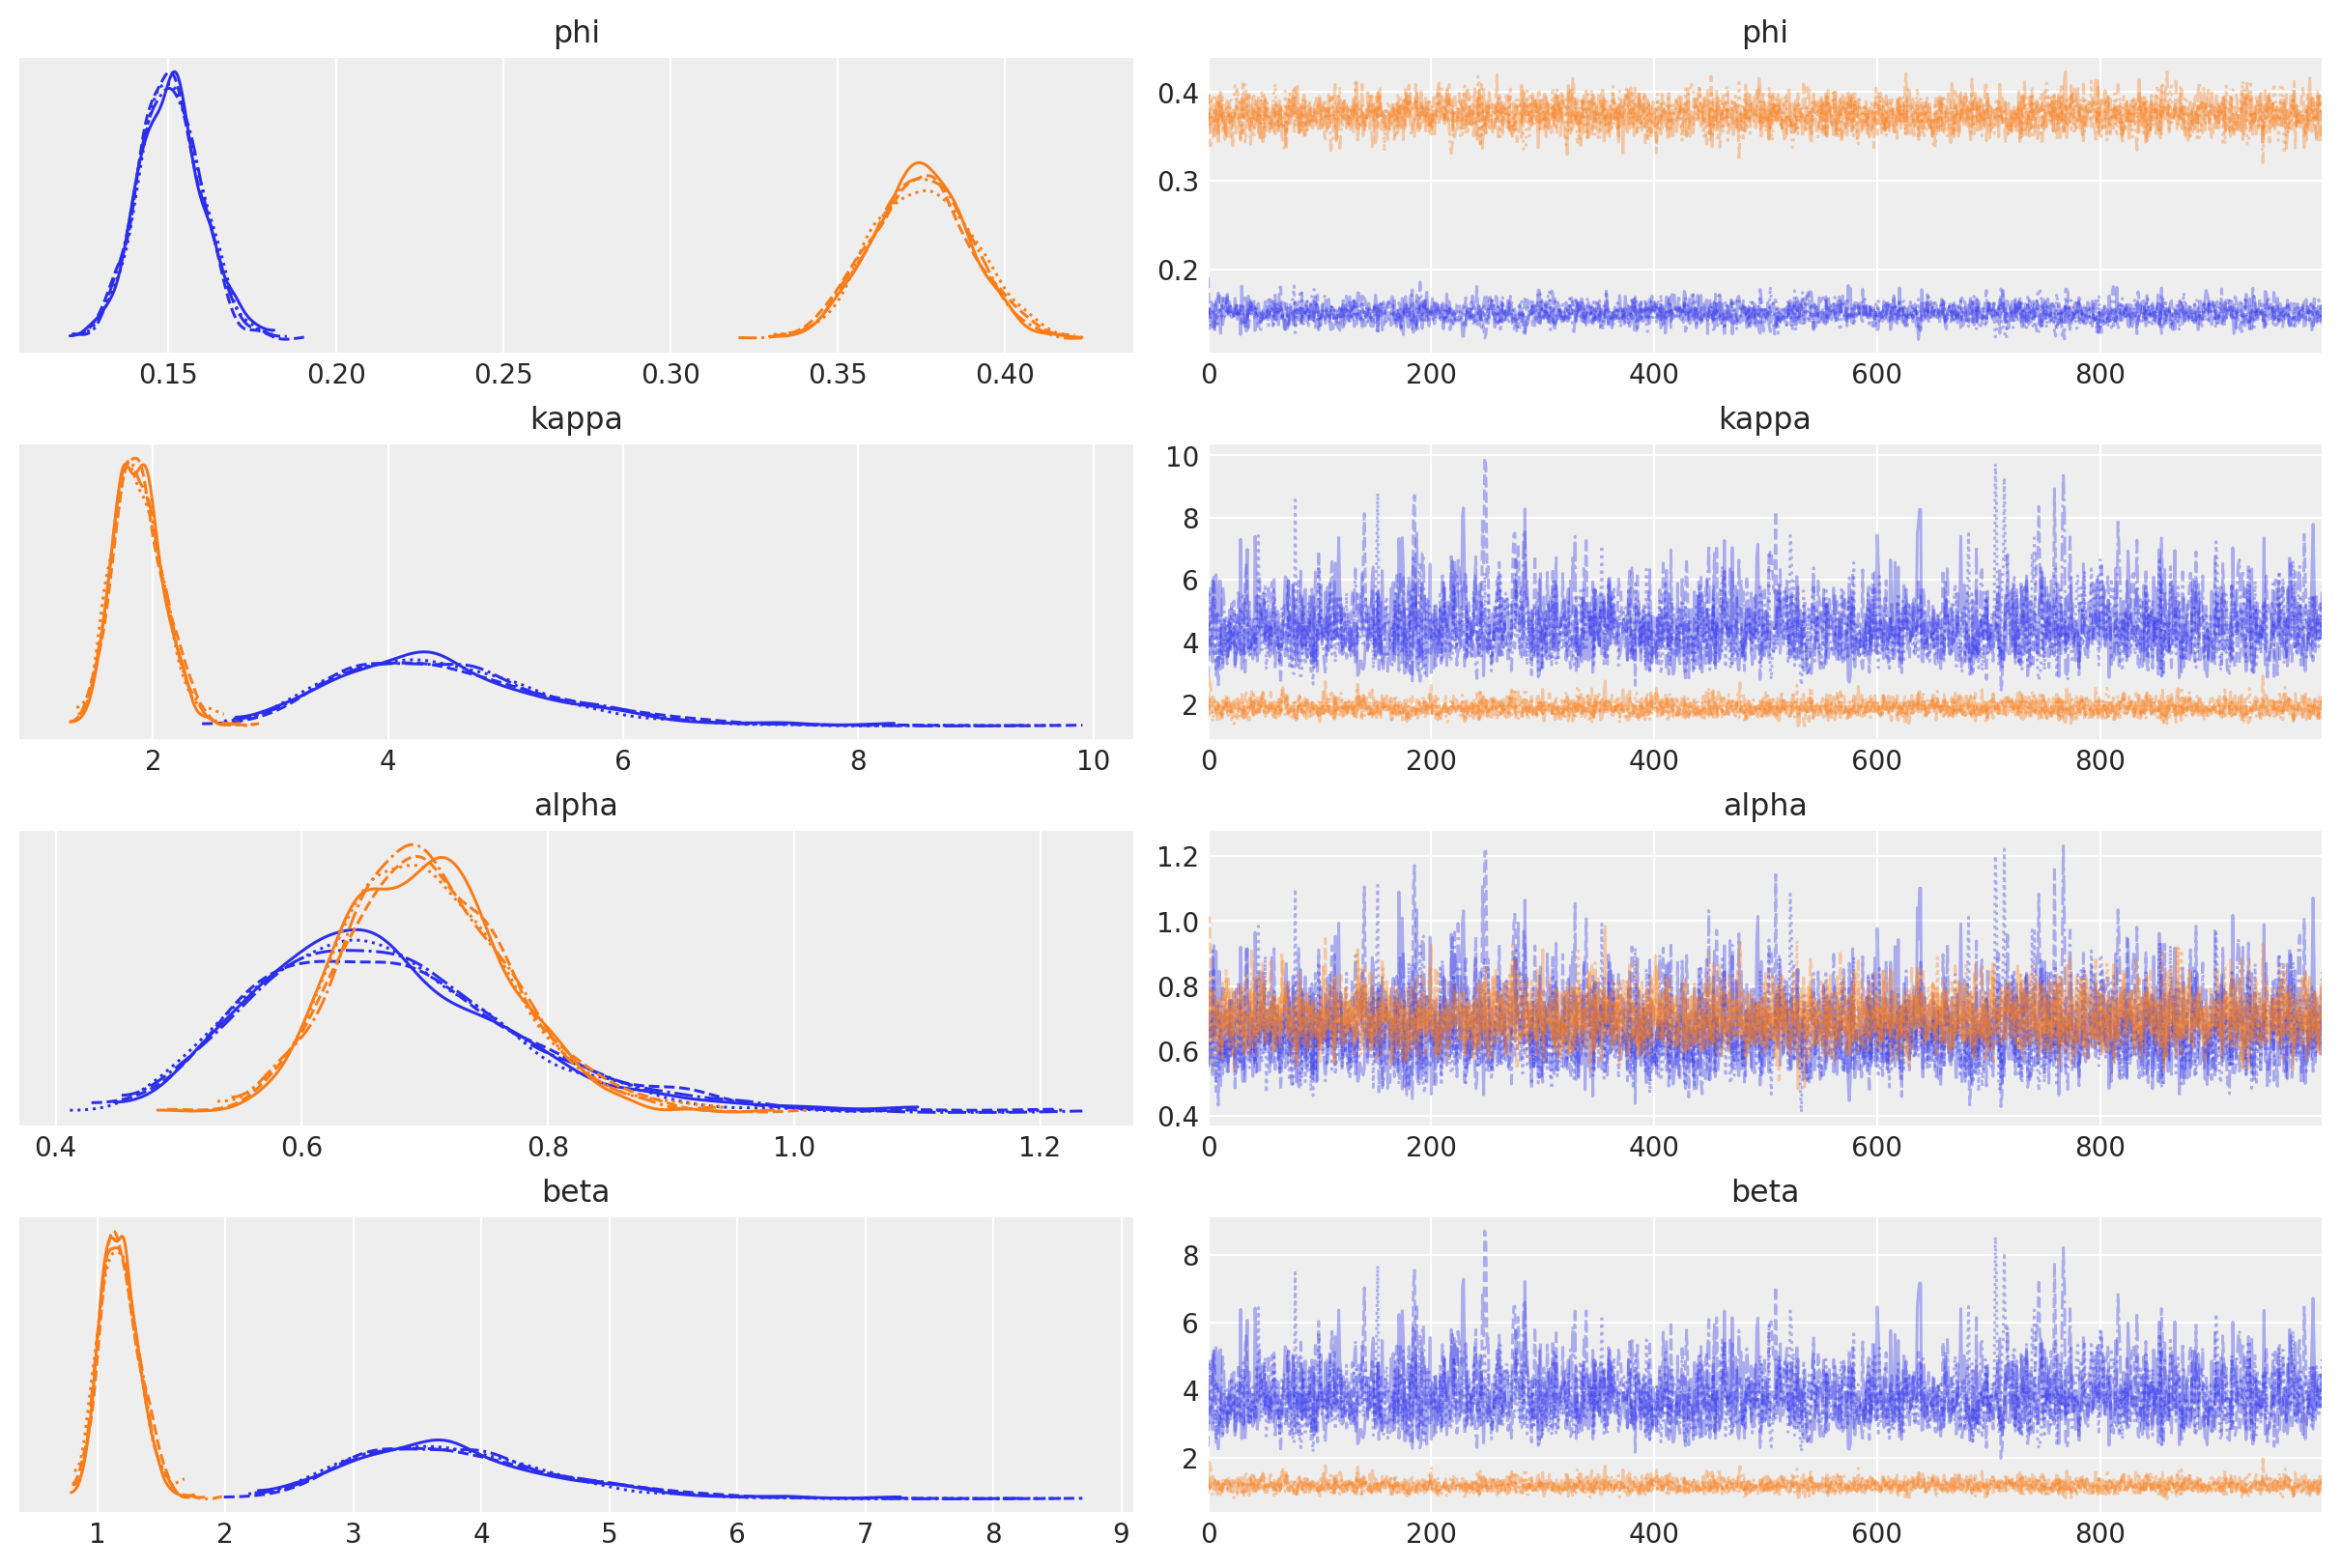

In [8]:
# MLE estimates from the paper
ref_val = {
    "highend": [0.668, 3.806],
    "regular": [0.704, 1.182],
}
sbg.fit_summary()
az.plot_trace(sbg.idata)

# Predictive Methods
Adapt plotting code from sBG-Individual notebook here.

In [ ]:
az.plot_hdi(
    weeks_,
    hi_retention.mean("customer_id"),
    hdi_prob=0.95,
    color="C0",
    fill_kwargs={"label": "high end"},
)
az.plot_hdi(
    weeks_,
    lo_retention.mean("customer_id"),
    hdi_prob=0.95,
    color="C1",
    fill_kwargs={"label": "regular"},
)

plt.plot(weeks_, retention_rate_highend_obs, color="k", label="observed")
plt.plot(weeks_, retention_rate_regular_obs, color="k")

plt.axvline(7, ls="--", color="k")
plt.ylim([0.5, 1.05])
plt.ylabel("Retention Rate")
plt.legend()
plt.title("Figure 5");

In [ ]:
obs = df["highend"]/100

plt.plot(survive_pred,color="b", label="predicted")
plt.plot(obs,color="k", label="observed")
plt.ylabel("Survival Rate")
plt.legend()
plt.title("High-End Customers MAP")

plt.plot(reg_retention_cohort[:8],color="b", label="predicted")
plt.plot(retention_rate_regular_obs[:8],color="k", label="observed")
plt.ylabel("Retention Rate")
plt.legend()
plt.title("Regular Customers MCMC Estimated with Cohorts")

In [120]:
pred_data=dataset.query("recency==T")
pred_cohort_retention = sbg.expected_retention_rate(pred_data,future_t=0).mean(("chain","draw"))

pred_cohort_retention.to_dataframe(name="retention").reset_index()

,cohort,customer_id,retention
0,highend,510,0.943356
1,highend,511,0.943356
2,highend,512,0.943356
3,highend,513,0.943356
4,highend,514,0.943356
...,...,...,...
727,regular,1996,0.921894
728,regular,1997,0.921894
729,regular,1998,0.921894
730,regular,1999,0.921894


In [10]:
max_T = 12
cohort_names = np.array(["regular","highend"])
cohorts_covar = np.array([0,1])
T_rng = np.arange(1,max_T+1,1)


pred_data = pd.DataFrame(
    {
        "customer_id": np.arange(1,1+max_T*2,1),
        "T": np.repeat(T_rng,len(cohort_names)),
        "cohort": np.tile(cohort_names,max_T),
        "covar_cohort": np.tile(cohorts_covar,max_T),
    }
)

# retention rate is estimated from T-1 time periods, reducing array length by 1
retention_array = pred_data.query("T <=12").copy()

sbg.expected_retention_rate(
            data=retention_array,
            future_t=0,
        )

# expected_purchases_over_time = xr.concat(
#     objs=[
#         sbg.expected_retention_rate(
#             data=time_data,
#             future_t=0,
#         )
#         for t in range(time_periods)
#     ],
#     dim="t",
# ).transpose(..., "t")

# unique_cohorts = np.unique(expected_purchases_over_time.coords["cohort"].values)

# for cohort in unique_cohorts:
#     print(expected_purchases_over_time.sel(cohort=cohort).mean("t"))

<xarray.DataArray (chain: 4, draw: 1000, cohort: 24)> Size: 768kB
array([[[0.62951802, 0.84867113, 0.75977221, ..., 0.95476117,
         0.94680287, 0.95772489],
        [0.60384425, 0.84428569, 0.74439688, ..., 0.95882269,
         0.94379771, 0.961644  ],
        [0.63632491, 0.8508947 , 0.75220794, ..., 0.9560969 ,
         0.94081085, 0.95899036],
        ...,
        [0.65425127, 0.85150647, 0.7614592 , ..., 0.95472686,
         0.94182992, 0.95766934],
        [0.65083677, 0.85652502, 0.76663508, ..., 0.95818918,
         0.94593594, 0.9609558 ],
        [0.62131393, 0.84093574, 0.74404207, ..., 0.95067278,
         0.93964529, 0.9538562 ]],

       [[0.63414359, 0.84827087, 0.74749498, ..., 0.95302861,
         0.93838708, 0.95606219],
        [0.62199884, 0.86944857, 0.76299553, ..., 0.95351813,
         0.94989398, 0.95633027],
        [0.63686201, 0.85777876, 0.76586858, ..., 0.95682148,
         0.94857136, 0.95963266],
...
        [0.60285917, 0.85779129, 0.74692593, ..., 0.95140599,
         0.94531201, 0.95440732],
        [0.64971732, 0.85464779, 0.76467102, ..., 0.95276528,
         0.94503895, 0.95575216],
        [0.64259456, 0.84811247, 0.76404716, ..., 0.95360479,
         0.9463521 , 0.95661786]],

       [[0.6237011 , 0.85594878, 0.75881244, ..., 0.95299106,
         0.94745979, 0.95595802],
        [0.62455278, 0.84512858, 0.74502869, ..., 0.95241569,
         0.9394204 , 0.95549853],
        [0.63437743, 0.84936187, 0.76858511, ..., 0.95814813,
         0.95045351, 0.96096698],
        ...,
        [0.61411976, 0.85068084, 0.76652115, ..., 0.95655719,
         0.95282729, 0.9594336 ],
        [0.6126816 , 0.84165242, 0.73841732, ..., 0.9533116 ,
         0.93839771, 0.95638698],
        [0.62208163, 0.8539768 , 0.74678488, ..., 0.94657999,
         0.94110921, 0.94976569]]], shape=(4, 1000, 24))
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * cohort       (cohort) object 192B 'regular' 'highend' ... 'highend'
    customer_id  (cohort) int64 192B 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24

# Additional Predictive Methods

Below methods are described in https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf, and will be added in a future PR.

### Simulate Data from Follow-Up Paper
Adapt below code to create time-period cohorts with highend & regular covariate customers mixed into each.

In [14]:
import numpy as np
import pandas as pd

# Cohort table from the markdown (empty cells omitted)
# only need the params for unit testing
# alpha 3.80, beta = 15.20
cohort_counts = {
    2001: {2001: 10000, 2002: 8000, 2003: 6480, 2004: 5307, 2005: 4391},
    2002: {2002: 10000, 2003: 8000, 2004: 6480, 2005: 5307},
    2003: {2003: 10000, 2004: 8000, 2005: 6480},
    2004: {2004: 10000, 2005: 8000},
    2005: {2005: 10000},
}

# alpha=0.067, beta=0.267
case2 = {
    2003: {2003: 10000, 2004: 8000, 2005: 7600, 2006: 7383, 2007: 7235},
    2004: {2004: 10000, 2005: 8000, 2006: 7600, 2007: 7383},
    2005: {2005: 10000, 2006: 8000, 2007: 7600},
    2006: {2006: 10000, 2007: 8000},
    2007: {2007: 10000},
}
# (Bottom totals row is intentionally ignored)

rows = []
for cohort, year_counts in cohort_counts.items():
    years_sorted = sorted(year_counts)
    ages = [y - cohort for y in years_sorted]
    S = [year_counts[y] for y in years_sorted]  # survivors per age
    last_t = ages[-1]  # observation window for this cohort (right-censoring time T)

    # Churn in interval t -> t+1 (event observed at t)
    for t in range(len(S) - 1):
        count = S[t] - S[t + 1]
        if count > 0:
            rows.append({"cohort": cohort, "t_churn": t, "T": last_t, "count": count})

    # Right-censored at last observed age (still active)
    if S[-1] > 0:
        rows.append({"cohort": cohort, "t_churn": last_t, "T": last_t, "count": S[-1]})

counts_df = pd.DataFrame(rows)

# Expand to one row per customer
t_churn_array = np.repeat(counts_df["t_churn"].to_numpy(), counts_df["count"].to_numpy())
T_array = np.repeat(counts_df["T"].to_numpy(), counts_df["count"].to_numpy())
cohort_array = np.repeat(counts_df["cohort"].to_numpy(), counts_df["count"].to_numpy())
customer_id = np.arange(t_churn_array.size)

df = pd.DataFrame(
    {
        "customer_id": customer_id + 1,
        "recency": t_churn_array + 1,
        "T": T_array + 1,
        "cohort": cohort_array,
    }
).astype({"customer_id": int, "t_churn": int, "T": int, "cohort": str})

#df.to_csv("sbg_cohorts.csv",index=False)

KeyError: "Only a column name can be used for the key in a dtype mappings argument. 't_churn' not found in columns."

##### Expected Retention Elasticity

In [74]:
    def expected_retention_elasticity(
        self,
        data: pd.DataFrame | None = None,
        *,
        discount_rate: float = 0.0,
    ) -> xarray.DataArray:
        """Compute expected retention elasticity.

        Adapted from equation (8) in [1]_.

        References
        ----------
        .. [1] Fader, P. S., & Hardie, B. G. (2010). Customer-Base Valuation in a Contractual Setting:
               The Perils of Ignoring Heterogeneity. Marketing Science, 29(1), 85-93.
               https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf
        """
        if data is None:
            data = self.data

        dataset = self._extract_predictive_variables(
            data, customer_varnames=["recency", "T"]
        )
        alpha = dataset["alpha"]
        beta = dataset["beta"]
        T = dataset["T"]

        retention_elasticity = hyp2f1(
            1, beta + T - 1, alpha + beta + 1, 1 / (1 + discount_rate)
        )
        # TODO: "cohorts" dim instead of "customer_id"?
        return retention_elasticity.transpose(
            "chain", "draw", "cohorts", "customer_id", missing_dims="ignore"
        )

AttributeError: 'ShiftedBetaGeoModel' object has no attribute 'expected_lifetime_purchases'

##### Discounted Expected Lifetime Renewals

In [75]:
sbg.expected_residual_lifetime(data,discount_rate)

AttributeError: 'ShiftedBetaGeoModel' object has no attribute 'expected_retention_elasticity'

### Latent Dropout Distribution for Customer Population
Distribution mean and polarization indices may be more pertinent to add in a future PR rather than visualizations of the marginalized posterior dropout distributions per cohort, but code to do so is provided below:

In [ ]:
alpha_fit = sbg.fit_result["alpha"]
beta_fit = sbg.fit_result["beta"]

rng = np.random.default_rng(42)
theta_sim = rng.beta(alpha_fit,beta_fit)

theta = xr.DataArray(
    theta_sim,
    dims=("chains","draws","cohort"),
    coords={
        "chains": np.arange(4), 
        "draws": np.arange(1000),
        "cohort": ["highend","regular"],
    },
    name="theta",
)

az_theta = az.convert_to_inference_data(theta)

highend = az_theta.sel(cohort="highend")
highend
highend.posterior["theta"].values.flatten()

az.plot_dist(highend.posterior["theta"].values.flatten())

az_theta.mean(("chains","draws"))

# plot this by cohort
theta
az.plot_dist(theta)

In [ ]:
# Map cohort-wise [alpha, beta] refs to ArviZ variable labels
ref_val_map = {}
for cohort, (a_ref, b_ref) in ref_val.items():
    ref_val_map[f"alpha\n{cohort}"] = a_ref
    ref_val_map[f"beta\n{cohort}"]  = b_ref
   
az.plot_posterior(
    idata,  # InferenceData; uses the posterior group by default
    var_names=["alpha", "beta"],
    ref_val=ref_val_map,
)

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Thu Oct 16 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pymc    : 5.25.1
pytensor: 2.31.7

pytensor      : 2.31.7
matplotlib    : 3.10.3
pymc          : 5.25.1
pymc_marketing: 0.15.1
xarray        : 2025.7.1
pymc_extras   : 0.4.0
pandas        : 2.3.1
numpy         : 2.2.6
arviz         : 0.22.0

Watermark: 2.5.0

